# Comparison of Face Detection Algorithms

## Objective
In this project, we test different face detection algorithms as made available in Python through OpenCV, DLib or other Deep Learning packages.
Since a dataset (Caltech) with ground truth bounding box coordinates has been made available, we evaluate the output of the detectors through some overlap measures.

## Overview
Throughout this project we follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info and (more importantly) code snippets for two "conventional" (HAAR-cascade, HOG) CV methods and Deep Neural Net (Dlib) based (MMOD) method. 

The face detector in the very concise [face_recognition package](https://face-recognition.readthedocs.io/en/latest/index.html) comes in 2 flavours: HOG and MMOD. This package is developed by Adam Geitgey on top of the DLib library developed by Davis King. It has a very convenient interface to face detection and recognition modules and can thus be substituted for the Dlib based code part. 

## Methods
There are available some publications on these detectors: 

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For the face_recognition package some info (for the face recognition part at least) can be found [here](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78).

## Implement and Validate
We apply these 3 techniques to the CALTECH Faces Dataset. 

Guidelines and probably some python code used has been found in: 
* [the face detection comparison tutorial](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/), more specifically (section 5) the issues of using a reasonable overlap measure (AP_50). 
* [general object detection validation - Cartucho](https://github.com/Cartucho/mAP)
* [general object detection validation - Padilla](https://github.com/rafaelpadilla/Object-Detection-Metrics)
* [mean Average Precision - Hui](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)
* [mean Average Precision - Arlen](https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3)

#### Import packages

In [1]:
import cv2
import os
from pathlib import Path
from scipy import io
from collections import namedtuple
import dlib
%matplotlib inline

In [2]:
#pretrained classifier
faceCascade = cv2.CascadeClassifier('/haarcascade_frontalface_alt.xml')

In [15]:
def ground_truth(datasetPath, ground_truth_path):
    
    #Get the ImageData.mat file provided
    imageFilePaths = datasetPath.rglob("*.jpg")

    bbData = io.loadmat(str(datasetPath) + '/ImageData.mat')
    bbData = bbData["SubDir_Data"].T
    
    Images = []
    
    for imageFilePath in imageFilePaths:
        
        file = imageFilePath.stem     
        f = open(ground_truth_path+'/'+file+'.txt', 'w') 
        
        image = cv2.imread(str(imageFilePath))
        imagePathStem = str(imageFilePath.stem)
        k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
        (xBL, yBL, xTL, yTL, xTR, yTR, xBR, yBR) = bbData[k].astype("int")

        Data = namedtuple('Image', 'path xTL, yTL, xBR, yBR')
        im1 = Data(path = str(imageFilePath),  xTL = xTL, yTL = yTL, xBR = xBR, yBR = yBR )
        Images.append(im1)
        
        f.write('face'+ ' ' + str(xTL)+ ' '+ str(yTL) + ' '+ str(xBR) + ' '+ str(yBR) ) 
        f.close() 
        
    return Images

datasetPath = '/CalTechFacesDirs'
ground_truth_path = '/Object-Detection-Metrics/groundtruths'

images = sorted(ground_truth(Path(datasetPath), ground_truth_path ))

In [16]:
def detection_method(algorithm, images, result_path):
    
    Data = namedtuple('Image', 'path w xTL, yTL, xBR, yBR')
    bboxes = []
    for image in images:
        img = cv2.imread(image.path)
        path, filename = os.path.split(image.path)
        file = filename.split('.')
        
        if not os.path.exists(resultsPath):
            os.makedirs(resultsPath)
            
        f = open(resultsPath+'/'+str(file[0])+'.txt', 'w') 
    
        bboxes = algorithm(img)

        for bbox in bboxes:        

            f.write('face'+ ' ' + str(bbox[0])+ ' '+  str(bbox[1]) + ' '+  str(bbox[2]) + ' '+  str(bbox[3]) + ' '+  str(bbox[4])+'\n' ) 
        f.close() 

### Detections with HAAR

In [0]:
def detectFaceOpenCVHaar(frame):
    
    inHeight=300
    inWidth=0
    
    frameOpenCVHaar = frame.copy()
    frameHeight = frameOpenCVHaar.shape[0]
    frameWidth = frameOpenCVHaar.shape[1]
    
    if not inWidth:
        inWidth = int((frameWidth / frameHeight) * inHeight)

    scaleHeight = frameHeight / inHeight
    scaleWidth = frameWidth / inWidth

    frameOpenCVHaarSmall = cv2.resize(frameOpenCVHaar, (inWidth, inHeight))
    frameGray = cv2.cvtColor(frameOpenCVHaarSmall, cv2.COLOR_BGR2GRAY)
    
    dets = faceCascade.detectMultiScale3(frameGray, minNeighbors=5, outputRejectLevels = True)
    faces = dets[0]
    neighbours = dets[1]
    weights = dets[2]
    
    bboxes = []
    for (x, y, w, h) in faces:
        x1 = x
        y1 = y
        x2 = x + w
        y2 = y + h
        w = weights[0][0]
        cvRect = [w, int(x1 * scaleWidth), int(y1 * scaleHeight),
                  int(x2 * scaleWidth), int(y2 * scaleHeight)]
        bboxes.append(cvRect)
    return bboxes

In [0]:
result_path = '/Object-Detection-Metrics/Detections_with_HAAR'
detection_method(detectFaceOpenCVHaar, images, result_path)

<function detectFaceOpenCVHaar at 0x0000022C1213D1E0>


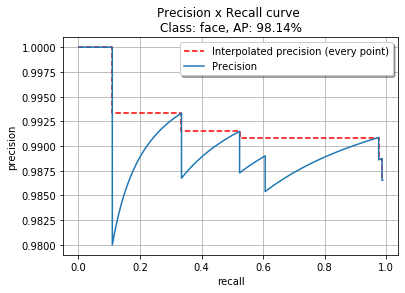

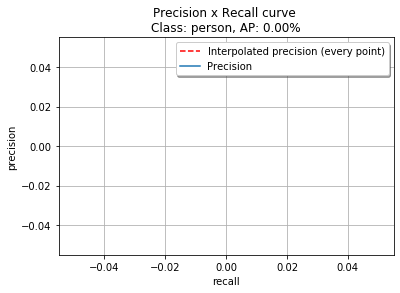

AP: 98.14% (face)
AP: 0.00% (person)
mAP: 49.07%


In [0]:
%run -i "/Object-Detection-Metrics/pascalvoc.py" -det "/Object-Detection-Metrics/Detections_with_HAAR"

### Detections with HOG

In [0]:
def detections_with_Hog(image):

    bboxes = []
    hogFaceDetector = dlib.get_frontal_face_detector()
    faceRects, scores, idx = hogFaceDetector.run(image, 0)
    for i in range(len(faceRects)):
        x1 = faceRects[i].left()
        y1 = faceRects[i].top()
        x2 = faceRects[i].right()
        y2 = faceRects[i].bottom()
        w = scores[i]
        bbox = [w, x1, y1, x2, y2]
        bboxes.append(bbox)
    return bboxes

In [0]:
result_path = '/Object-Detection-Metrics/Detections_with_HOG'
detection_method(detections_with_Hog, images, result_path)

<function detections_with_Hog at 0x0000010CF85E61E0>


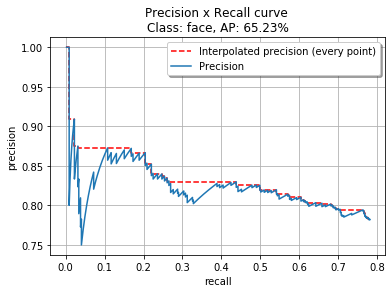

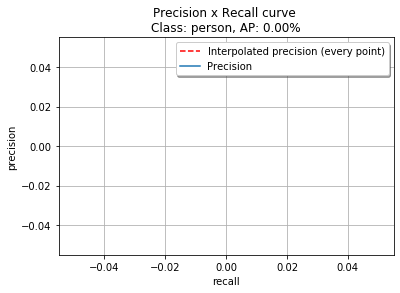

AP: 65.23% (face)
AP: 0.00% (person)
mAP: 32.62%


In [0]:
%run -i "/Object-Detection-Metrics/pascalvoc.py" -det "/Object-Detection-Metrics/Detections_with_HOG"

In [0]:
dnnFaceDetector = dlib.cnn_face_detection_model_v1("/mmod_human_face_detector.dat")

### Detections with Max-Margin Object Detection (MMOD)

In [19]:
def detections_with_MMOD(image):

    bboxes = []
   
    faceRects = dnnFaceDetector(image, 1)
    for i, faceRect in enumerate(faceRects):
        x1 = faceRect.rect.left()
        y1 = faceRect.rect.top()
        x2 = faceRect.rect.right()
        y2 = faceRect.rect.bottom()
        w = faceRect.confidence
        bbox = [w, x1, y1, x2, y2]
        bboxes.append(bbox)
        
    return bboxes

In [ ]:
result_path = '/Object-Detection-Metrics/Detections_with_MMOD'
detection_method(detections_with_MMOD, images, result_path)

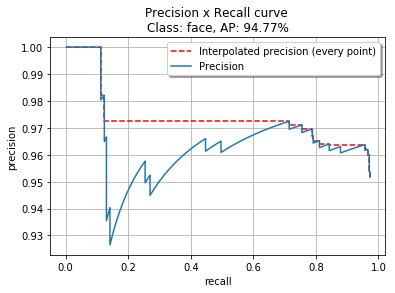

AP: 94.77% (face)
mAP: 94.77%


In [18]:
%run -i '/Object-Detection-Metrics/pascalvoc.py' -det '/Object-Detection-Metrics/Detections_with_Mmod' 


## Results - Conclusion:

Judging from the results acquired when detecting using HOG, HAAR and MMOD, HAAR had the best perfomance with AP:98.14% in the precision-recall curve, while HOG had the worst with AP: 65.23% in the precision-recall curve.  